# Customer Support on Twitter

Author: Ramy Ghorayeb
    
Access the competition [here](https://www.kaggle.com/thoughtvector/customer-support-on-twitter#sample.csv)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Sample discovery

In [120]:
sample = pd.read_csv('data/sample.csv')

In [6]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 7 columns):
tweet_id                   93 non-null int64
author_id                  93 non-null object
inbound                    93 non-null bool
created_at                 93 non-null object
text                       93 non-null object
response_tweet_id          65 non-null object
in_response_to_tweet_id    68 non-null float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 4.5+ KB


In [55]:
sample.loc[:5]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,119237,105834,True,Wed Oct 11 06:55:44 +0000 2017,@AppleSupport causing the reply to be disregar...,119236,NaN
1,119238,ChaseSupport,False,Wed Oct 11 13:25:49 +0000 2017,@105835 Your business means a lot to us. Pleas...,NaN,119239.0
2,119239,105835,True,Wed Oct 11 13:00:09 +0000 2017,@76328 I really hope you all change but I'm su...,119238,NaN
3,119240,VirginTrains,False,Tue Oct 10 15:16:08 +0000 2017,@105836 LiveChat is online at the moment - htt...,119241,119242.0
4,119241,105836,True,Tue Oct 10 15:17:21 +0000 2017,@VirginTrains see attached error message. I've...,119243,119240.0
5,119243,VirginTrains,False,Tue Oct 10 15:25:14 +0000 2017,"@105836 Have you tried from another device, Mi...",119244,119241.0


In [108]:
for i in sample.loc[:5][['author_id','text']].iterrows():
    print('# Author :',i[1][0],'--',i[1][1])

# Author : 105834 -- @AppleSupport causing the reply to be disregarded and the tapped notification under the keyboard is opened😡😡😡
# Author : ChaseSupport -- @105835 Your business means a lot to us. Please DM your name, zip code and additional details about your concern. ^RR https://t.co/znUu1VJn9r
# Author : 105835 -- @76328 I really hope you all change but I'm sure you won't! Because you don't have to!
# Author : VirginTrains -- @105836 LiveChat is online at the moment - https://t.co/SY94VtU8Kq or contact 03331 031 031 option 1, 4, 3 (Leave a message) to request a call back
# Author : 105836 -- @VirginTrains see attached error message. I've tried leaving a voicemail several times in the past week https://t.co/NxVZjlYx1k
# Author : VirginTrains -- @105836 Have you tried from another device, Miriam ^MM


## Data Exploration

In [128]:
data = pd.read_csv('data/twcs.zip', compression='zip')

Explore companies

In [152]:
companies = data[data['author_id'].apply(lambda x:not x.isdigit())]

In [165]:
companies_count = companies.groupby(['author_id']).count()

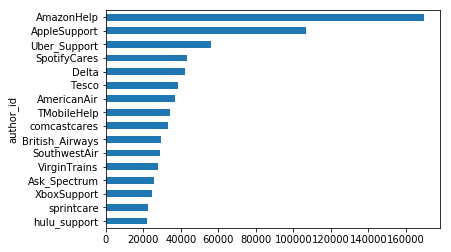

In [186]:
companies_count[companies_count['tweet_id']>20000]['tweet_id'].sort_values().plot(kind='barh')

Let's focus on AmazonHelp customer support for this exercise

In [242]:
sample['author_id'][0]

'105834'

In [249]:
for i in sample.iteritems():
    print(i[1])

0              105834
1        ChaseSupport
2              105835
3        VirginTrains
4              105836
5        VirginTrains
6              105836
7        VirginTrains
8              105836
9        VirginTrains
10       AppleSupport
11             105837
12             105838
13       AppleSupport
14             105839
15       SpotifyCares
16             105840
17       SpotifyCares
18             105840
19       SpotifyCares
20             105840
21       SpotifyCares
22             105840
23       AppleSupport
24             105841
25    British_Airways
26             105842
27       AppleSupport
28             105843
29       AppleSupport
           ...       
63             105842
64    British_Airways
65       Ask_Spectrum
66             105854
67             105854
68              Tesco
69             105855
70             105855
71              Tesco
72             105855
73              Tesco
74             105855
75              Tesco
76             105856
77        